In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 KB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.6 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=68f4ed0eac4ae300963f28d373bd26a61d6fa8dc4d142bc5f561fc9a76b462e3
  Stored in directory: /root/.cache/pip/wheels/4c/8e/7e/72fbc243e1aeecae64a96875432e70d4e92f3d2d18123be004
Successfully built pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


# Library Import

In [ ]:
import random
import tarfile
import cv2
from torchvision.datasets.utils import download_url
import torchvision.transforms as tt
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from sklearn.metrics import f1_score,confusion_matrix
import os
import torch

import wandb
import torch.nn as nn
import scipy.io
import numpy as np
import albumentations as A

In [ ]:
wandb.login()
wandb.init(project="CV_A1_Q2_Q2_1", entity="iiitd")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: manvendra (iiitd). Use `wandb login --relogin` to force relogin


In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
import zipfile
with zipfile.ZipFile(r'/gdrive/MyDrive/CV/A1/VOC Segmentation Dataset.zip', 'a') as zip_ref:
    zip_ref.extractall(path = r'/content/datai')

# Define Utility Function

In [ ]:
    VOC_COLORMAP = [
        [0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
        [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
        [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
        [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
        [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0], [0, 64, 128]
    ]

    VOC_CLASSES = [
        'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
        'car', 'cat', 'chair', 'cow', 'dining table', 'dog', 'horse', 'motorbike',
        'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv monitor'
    ]
def process_mask(rgb_mask, colormap):
      output_mask = []

      for i, color in enumerate(colormap):
          cmap = np.all(np.equal(rgb_mask, color), axis=-1)
          output_mask.append(cmap)
      output_mask = np.stack(output_mask, axis=-1)
      return output_mask



In [ ]:
# from PIL import Image
# import numpy as np
# mask = np.asarray(Image.open('/content/datai/VOC Segmentation Dataset/masks/2007_000039.png').convert('RGB'))

# Define Data Class

In [ ]:
from PIL import Image
class DataSet:
  def __init__(self,path,transform_img = None,transform_msk = None,transform_aug = None):
      self.all_name = []
      self.path = path
      for i in os.listdir(path+'images/'):
        name,_ = os.path.splitext(i) 
        self.all_name.append(name)
      self.transform_img = transform_img
      self.transform_msk = transform_msk
      self.transform_aug = transform_aug
  
  def __getitem__(self,index):
    name = self.all_name[index]
    # img = np.asarray(Image.open(self.path+'images/'+name+'.jpg').convert('RGB'))
    # msk = np.asarray(Image.open(self.path+'masks/'+name+'.png').convert('RGB'),dtype ='int64')
    img = Image.open(self.path+'images/'+name+'.jpg').convert('RGB')
    msk = Image.open(self.path+'masks/'+name+'.png').convert('RGB')
    #print(img.shape,msk.shape)
    # img = Image.open(self.path+'images/'+name+'.jpg')
    # msk = Image.open(self.path+'masks/'+name+'.png')


    p = random.randint(0,1)
    
    if p==1:
      img = tt.functional.vflip(img)
      msk = tt.functional.vflip(msk)
    p = random.randint(0,1)
    if p==1:
      img = tt.functional.hflip(img)
      msk = tt.functional.hflip(msk)
    p = random.randint(0,1)
    if p==1:
      img = tt.functional.rotate(img, angle=5.0)
      msk = tt.functional.rotate(msk, angle=5.0)


    img = np.asarray(img)
    msk = np.asarray(msk)
        # img = tt.ToTensor()(img)
        # img = tt.RandomVerticalFlip(p)(img)
        # img = tt.RandomRotation(p)(img)
        # img = tt.RandomHorizontalFlip(p)(img).permute(1,2,0).numpy()
        
        # msk = tt.ToTensor()(msk)
        # msk = tt.RandomVerticalFlip(p)(msk)
        # msk = tt.RandomRotation(p)(msk)
        # msk = tt.RandomHorizontalFlip(p)(msk).permute(1,2,0).numpy()

        # msk = tt.RandomRotation(p,degrees=10)(msk)
        # img = np.asarray(img)
        # msk = np.asarray(msk)
        # img = A.HorizontalFlip(p=p)(image = img)['image']
        # img = A.VerticalFlip(p=p)(image = img)['image']
        # img = A.GridDistortion(p=p)(image = img)['image']
        # msk = A.HorizontalFlip(p=p)(image = msk)['image']
        # msk = A.VerticalFlip(p=p)(image = msk)['image']
        # msk = A.GridDistortion(p=p)(image = msk)['image']
        
        #temp = np.concatenate(np.expand_dims(img,0), np.expand_dims(msk,0),0)
        #temp = self.transform_aug (temp)
        #img = temp[0]
        #msk = temp[1]
        # img = self.transform_aug (img)
        # tt.ReplayCompose.replay(img['replay'], image=image2)

    # print(img.shape,msk.shape)
    if self.transform_img is not None:
        img = self.transform_img (img)
    
    pmsk = process_mask(msk,VOC_COLORMAP)
    lablmask = np.argmax(pmsk, axis=-1)
  
    if self.transform_msk is not None:
        msk = self.transform_msk(lablmask )

    return img , msk.squeeze(0)

  def __len__(self):
    return len(self.all_name)


In [ ]:

trans_img = tt.Compose([
    tt.ToTensor(),tt.Resize((256,192)),tt.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
trans_mask = tt.Compose([
    tt.ToTensor(),tt.Resize((256,192))
])

data = DataSet('/content/datai/VOC Segmentation Dataset/',trans_img,trans_mask)

In [ ]:
data[0]

(tensor([[[-2.0481, -2.1062, -1.9802,  ..., -2.0514, -2.0957, -1.9511],
          [-2.0613, -2.0927, -1.9653,  ..., -1.7225, -1.9511, -1.9213],
          [-2.0760, -2.0611, -1.9082,  ..., -1.6661, -1.8165, -1.8737],
          ...,
          [ 0.6401,  0.6998,  0.8036,  ..., -1.2349,  0.6841, -1.0701],
          [ 0.6562,  0.8494,  0.6311,  ...,  0.9258, -0.5106,  0.4582],
          [ 0.7154,  0.7549,  0.6282,  ...,  0.7828,  0.8987, -1.1267]],
 
         [[-1.8078, -1.8507, -1.7820,  ..., -1.4877, -1.7446, -1.4162],
          [-1.8399, -1.8634, -1.6899,  ..., -0.9379, -1.4441, -1.3120],
          [-1.8440, -1.8297, -1.5928,  ..., -0.7069, -1.1067, -1.2277],
          ...,
          [ 1.0508,  1.0937,  1.2312,  ..., -0.6920,  1.0017, -0.5489],
          [ 1.0901,  1.2552,  1.0217,  ...,  1.1617, -0.0296,  0.8250],
          [ 1.1197,  1.1759,  1.0194,  ...,  0.9573,  1.0528, -0.3766]],
 
         [[-1.4846, -1.5083, -1.2755,  ..., -0.9334, -1.3071, -1.0837],
          [-1.4620, -1.4669,

In [ ]:
test_size = int(len(data)*0.1)
val_size = int(len(data)*0.2)
train_size = len(data)-test_size-val_size

train_ds, val_ds ,test_ds = random_split(data, [train_size,val_size, test_size])

print(len(train_ds), len(val_ds),len(test_ds))

1026 292 146


In [ ]:
batch =8

# Define Data Loader

In [ ]:
train_dl = DataLoader(train_ds, batch, shuffle=True)
val_dl = DataLoader(val_ds, batch, shuffle=True)
test_dl = DataLoader(test_ds, batch, shuffle=True)

In [ ]:
train_dist=[0 for i in range(21)]

In [ ]:
for i,j in train_ds:
    for k in (torch.unique(j)):
      train_dist[(k.item())]+=1


<BarContainer object of 21 artists>

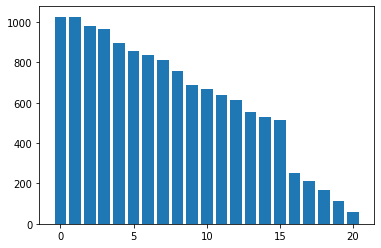

In [ ]:
plt.bar(range(21),train_dist)

In [ ]:
test_dist=[0 for i in range(21)]

In [ ]:
for i,j in test_ds:
    for k in (torch.unique(j)):
      test_dist[(k.item())]+=1


<BarContainer object of 21 artists>

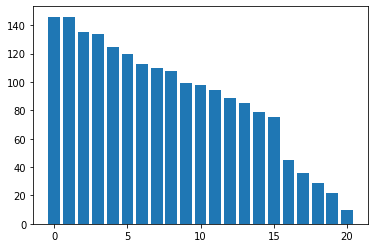

In [ ]:
plt.bar(range(21),test_dist)

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/functional.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


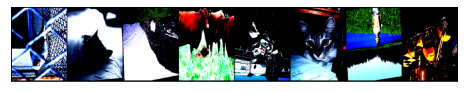

In [ ]:
from torchvision.utils import make_grid
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, label in dl:
        #print(label[:64])
        show_images(images, nmax)
        break

show_batch(train_dl,64)

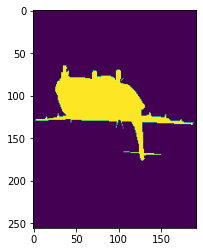

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, label in dl:
        for j in label:
          plt.imshow(j)        
          break
        break

show_batch(train_dl)

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])


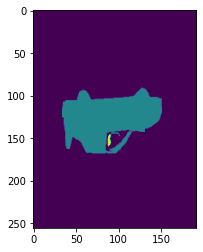

In [ ]:
for i,h in train_dl:
  for n in h:
    plt.imshow(n.squeeze(0))
    print(n)
    break
  break


# Defining Model and Utility Function

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)
train_dl = DeviceDataLoader(train_dl,'cuda')
val_dl = DeviceDataLoader(val_dl,'cuda')
test_dl = DeviceDataLoader(val_dl,'cuda')

In [ ]:
def accuracy(pred, label):
    _, tags = torch.max(pred, dim = 1)
    corrects = (tags == label).float()
    acc = corrects.sum() / corrects.numel()
    
    return acc

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    model = torchvision.models.segmentation.fcn_resnet50()
    #model.classifier[4] = torch.nn.Conv2d(512, 20, kernel_size=(1, 1), stride=(1, 1))
    #model.aux_classifier[4] =torch.nn.Conv2d(512, 20, kernel_size=(1, 1), stride=(1, 1))
    self.network = model
  def forward(self, x):
    return self.network(x)['out']
  
  def train_step(self,batch):
      img , label = batch
      pred = self(img)
      loss_fn = nn.CrossEntropyLoss()
      #loss = loss_fn(pred,to_device(label.type(torch.LongTensor),'cuda'))
      loss = loss_fn(pred,label)
      return loss


  def valid_step(self,batch):
      img , label = batch
      pred = self(img)
      loss_fn = nn.CrossEntropyLoss()
      #loss = loss_fn(pred,to_device(label.squeeze(1),'cuda'))
      # loss = loss_fn(pred,label)
      #loss = loss_fn(pred,to_device(label.type(torch.LongTensor),'cuda'))
      loss = loss_fn(pred,label)
      acc = accuracy(pred, label)
      return {'acc':acc.item() , 'loss':loss.item()}

  def valid_metric_cals(self,output):
    loss = [i['loss'] for i in output]
    acc = [i['acc'] for i in output]
    valid_loss = np.mean(loss)
    valid_acc = np.mean(acc)
    return {'val_loss':valid_loss,'valid_acc':valid_acc}
  
  def epoch_end(self, epoch_no , result):
    wandb.log({ 'epoch' : epoch_no+1, 'training loss': result["train_loss"], 'validation loss': result["val_loss"], 'accuracy': result["valid_acc"]})
    print(f'epoch :{epoch_no+1}, training loss: {result["train_loss"]}, validation loss: {result["val_loss"]},accuracy: {result["valid_acc"]}')

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
@torch.no_grad()
def evalu(model, val_dl):
  model.eval()
  temp = [ model.valid_step(j) for j in val_dl ]
  return model.valid_metric_cals(temp)

def fit(train_dl,val_dl,model,lr,optim,epochs):
  history = []
  optimizer =  optim(model.parameters(),lr=lr)
  
  for epoch in range(epochs):
    train_loss = []
    model.train()
    for batch in tqdm(train_dl):
      optimizer.zero_grad()
      loss = model.train_step(batch)
      loss.backward()
      train_loss.append(loss.item())
      optimizer.step()
      
    result = evalu(model,val_dl)
    result['train_loss'] = np.mean(train_loss)
    history.append(result)
    model.epoch_end(epoch,result)
  return history

    

In [ ]:
model = Model()
model.train()
wandb.watch(model)
model = to_device(model,'cuda')
lr = 0.008
optimizer= torch.optim.SGD
epochs=7
wandb.config = {'lr':lr,'optimuzer':'SGD','epochs':epochs,'batch_size':batch}

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

# Training

In [ ]:
history=fit(train_dl,val_dl,model,lr,optimizer,epochs)

  0%|          | 0/129 [00:00<?, ?it/s]

epoch :1, training loss: 0.9721099431662596, validation loss: 0.6618014630433675,accuracy: 0.8075607773419973


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :2, training loss: 0.6632062961426817, validation loss: 0.5806222920482224,accuracy: 0.8250492070172284


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :3, training loss: 0.5899476827115051, validation loss: 0.5475275178213377,accuracy: 0.8412530744397962


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :4, training loss: 0.5505256324775459, validation loss: 0.5142533730816197,accuracy: 0.850659914918848


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :5, training loss: 0.5028386471807494, validation loss: 0.5166840202905036,accuracy: 0.84706145363885


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :6, training loss: 0.49220918661864227, validation loss: 0.5299258675124194,accuracy: 0.8452540410531534


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :7, training loss: 0.45540474193502767, validation loss: 0.4929118869272438,accuracy: 0.8562303330447223


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :8, training loss: 0.4280731456224309, validation loss: 0.49393672475943695,accuracy: 0.8557815777288901


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :9, training loss: 0.42333335192628607, validation loss: 0.4858808944354186,accuracy: 0.8572296467987267


  0%|          | 0/129 [00:00<?, ?it/s]

epoch :10, training loss: 0.39905006698397705, validation loss: 0.47454913927091136,accuracy: 0.859685209957329


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

25

In [ ]:
models = torch.load(r'/gdrive/MyDrive/CV/A1/model (1).pth',map_location=torch.device('cpu'))
model = Model()
model.load_state_dict(models)
#model = to_device(model,'cuda')

<All keys matched successfully>

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Calculating Cuustom Metrics

In [ ]:
metrics = {'Iou':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'AP':[torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21)), torch.tensor(np.zeros(21))],'F1':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'Accuracy':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           'Recall':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'Precision':[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],'count':[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


from torchmetrics import JaccardIndex
from torchmetrics import Dice
from torchmetrics import AveragePrecision
from torchmetrics import Accuracy
from torchmetrics import Precision
from torchmetrics import Recall

with torch.no_grad():
  model.eval()
  for count,i in enumerate(test_dl):  
    a,b = i
    z = model(a)
    jaccard = JaccardIndex(task="multiclass",average='weighted' ,num_classes=21)#,average =None 
    average_precision = AveragePrecision(task="multiclass", num_classes=21,average=None)#average =None
    dice = Dice(num_classes=21)
    acc = Accuracy(task="multiclass",average='weighted', num_classes=21)
    prec = Precision(task="multiclass",average='weighted', num_classes=21)
    recal = Recall(task="multiclass",average='weighted',num_classes=21)
    
    
    idx = jaccard(z.cpu(), b.cpu()).item()
    metrics['count'][round(idx*10)]+=1
    metrics['Iou'][round(idx*10)]+=idx
    metrics['AP'][round(idx*10)]+=average_precision(z.cpu(), b.cpu())
    #print(average_precision(z.cpu(), b.cpu()).shape)
    metrics['F1'][round(idx*10)]+=dice(z.cpu(), b.cpu()).item()
    metrics['Accuracy'][round(idx*10)]+=acc(z.cpu(), b.cpu()).item()
    metrics['Precision'][round(idx*10)]+=prec(z.cpu(), b.cpu()).item()
    metrics['Recall'][round(idx*10)]+=recal(z.cpu(), b.cpu()).item()
    torch.cuda.empty_cache()
    gc.collect()
    


Mounted at /content/drive


In [ ]:

from torchmetrics import JaccardIndex
from torchmetrics import Dice
from torchmetrics import AveragePrecision
from torchmetrics import Accuracy
from torchmetrics import Precision
from torchmetrics import Recall

model.eval()
with torch.no_grad():
  for count,i in enumerate(test_dl):  
      a,b = i
      z = model(a)
      print(count)
      for l in range(0,10):  
        jaccard = JaccardIndex(task="multiclass",average='weighted' ,num_classes=21)#,average =None 
        average_precision = AveragePrecision(task="multiclass", num_classes=21,average=None,threshold =round(0.1+0.1*l ,2))#average =None
        dice = Dice(num_classes=21)
        acc = Accuracy(task="multiclass",average='weighted', num_classes=21,threshold =round(0.1+0.1*l ,2))
        prec = Precision(task="multiclass",average='weighted', num_classes=21,threshold =round(0.1+0.1*l ,2))
        recal = Recall(task="multiclass",average='weighted',num_classes=21,threshold =round(0.1+0.1*l ,2))    
        

        idx = jaccard(z.cpu(), b.cpu()).item()
        metrics1['count'][l]+=1
        metrics1['Iou'][l]+=idx
        metrics1['AP'][l]+=average_precision(z.cpu(), b.cpu())
        #print(average_precision(z.cpu(), b.cpu()).shape)
        metrics1['F1'][l]+=dice(z.cpu(), b.cpu()).item()
        metrics1['Accuracy'][l]+=acc(z.cpu(), b.cpu()).item()
        metrics1['Precision'][l]+=prec(z.cpu(), b.cpu()).item()
        metrics1['Recall'][l]+=recal(z.cpu(), b.cpu()).item()
        torch.cuda.empty_cache()
        gc.collect()



In [ ]:
metrics1

In [ ]:
from operator import truediv
for i,j in metrics.items():
  print()
  print(i)
  print(np.sum(np.array(j))/(count+1))




Iou
0.7772273791802896

AP
tensor([0.9802, 0.3901, 0.0156, 0.2248, 0.1384, 0.1898, 0.3413, 0.2568, 0.4754,
        0.1328, 0.2126, 0.2507, 0.3598, 0.2045, 0.1802, 0.6233,    nan,    nan,
           nan,    nan,    nan], dtype=torch.float64)

F1
0.8615490310900921

Accuracy
0.861549035922901

Recall
0.861549035922901

Precision
0.8679256503646439

count
1.2702702702702702


<ipython-input-28-dfc2c08525cd>:5: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  print(np.sum(np.array(j))/(count+1))
<ipython-input-28-dfc2c08525cd>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  print(np.sum(np.array(j))/(count+1))


In [ ]:
count=0
for z in range(10):
  print(f'For IOU range {round(count,2)} - {round(count+0.1,2)}')
  for i,j in metrics.items():
    print(i)
    print()
    print(j[z]/np.array(metrics['count'][z]))
  count+=0.1
  print()


For IOU range 0 - 0.1
Iou

0.0
AP

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
F1

0.0
Accuracy

0.0
Recall

0.0
Precision

0.0
count

1.0

For IOU range 0.1 - 0.2
Iou

0.0
AP

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
F1

0.0
Accuracy

0.0
Recall

0.0
Precision

0.0
count

1.0

For IOU range 0.2 - 0.3
Iou

0.0
AP

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
F1

0.0
Accuracy

0.0
Recall

0.0
Precision

0.0
count

1.0

For IOU range 0.3 - 0.4
Iou

0.0
AP

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64)
F1

0.0
Accuracy

0.0
Recall

0.0
Precision

0.0
count

1.0

For IOU range 0.4 - 0.5
Iou

0.0
AP

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [ ]:
import cv2
@torch.no_grad()
def false_image_list(test_dl):
  
  model.eval()
  img_list = []
  for num,(img,label) in enumerate(test_dl):
    outputs = model(img)
    pred_map = torch.argmax(outputs,dim=1)
    for idx in range(img.shape[0]):
      if ( not( pred_map[idx] == label[idx]).all() ) and (jaccard(outputs[idx].cpu().unsqueeze(0),label[idx].cpu().unsqueeze(0))<=0.5):
          
          sub = cv2.subtract(label[idx].detach().cpu().numpy(),pred_map[idx].detach().cpu().numpy())
          coords = np.argwhere(sub > 0)
          try:
            img_list.append(   [img[idx].detach().cpu().permute(1,2,0).numpy(), pred_map[idx].detach().cpu().numpy(), label[idx].detach().cpu().numpy(), np.unique(label[idx] [coords].cpu()) ]   )
          except:
            pass
  return img_list
img_list  =  false_image_list(test_dl)

In [ ]:
z ={i:[] for i in range(21)}
for i in img_list:
  for j in i[3]:
    if len(z[j])<3:
      z[j].extend(i)
      break

# Visualization for Prediction and Targets

For class 0


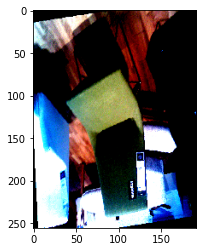

predicted


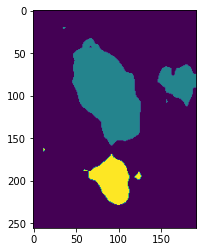

original


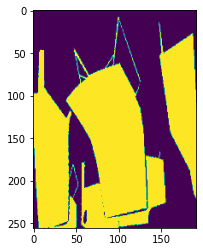

------------------------------------------------
For class 1


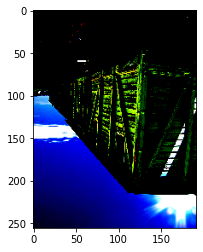

predicted


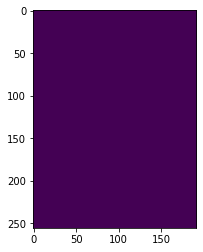

original


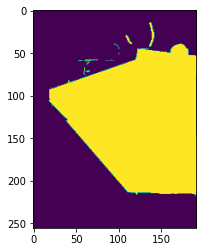

------------------------------------------------
For class 2


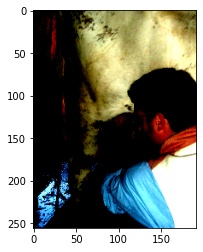

predicted


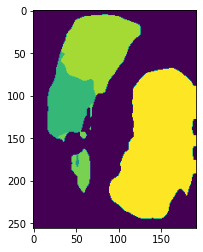

original


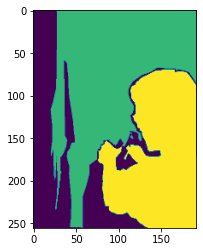

------------------------------------------------
For class 3


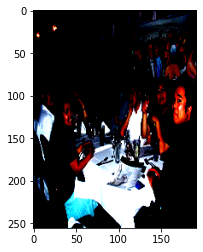

predicted


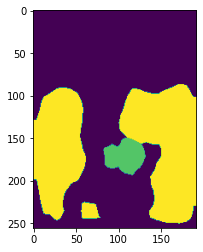

original


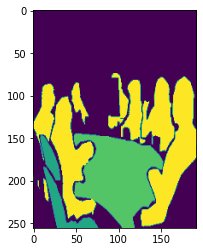

------------------------------------------------
For class 4


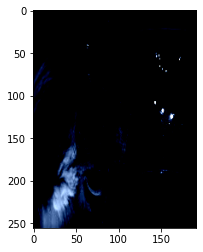

predicted


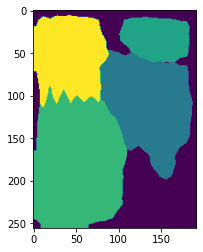

original


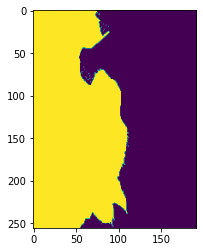

------------------------------------------------
For class 5


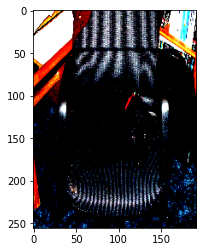

predicted


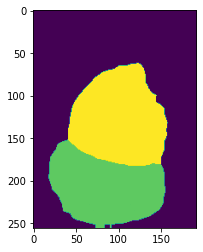

original


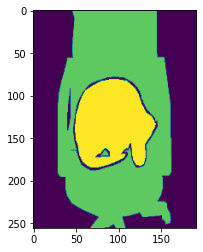

------------------------------------------------
For class 6


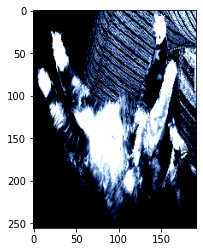

predicted


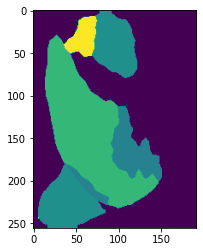

original


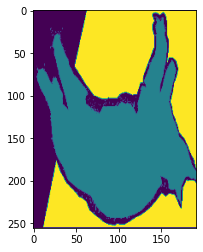

------------------------------------------------
For class 7


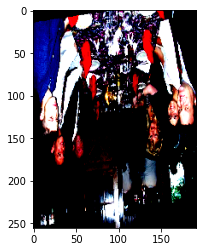

predicted


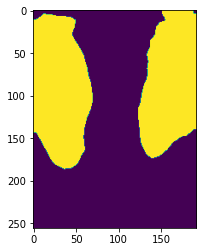

original


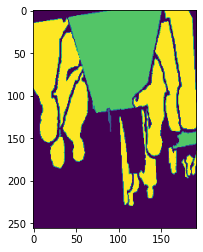

------------------------------------------------
For class 8


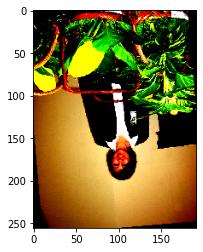

predicted


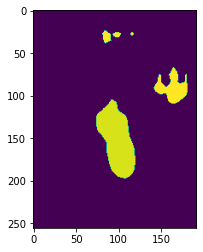

original


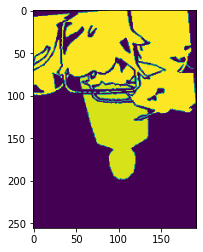

------------------------------------------------
For class 9


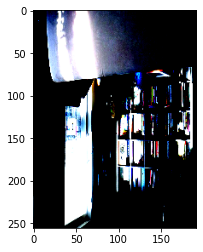

predicted


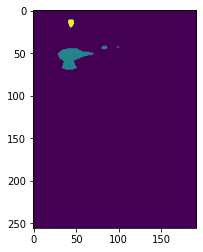

original


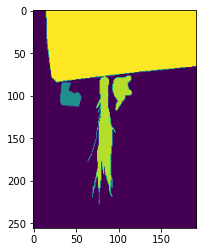

------------------------------------------------
For class 10


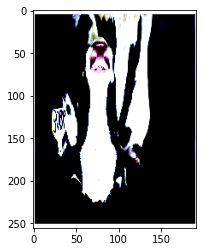

predicted


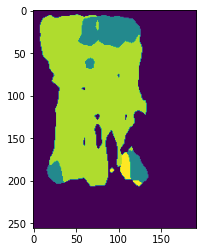

original


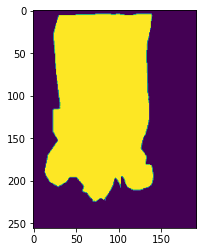

------------------------------------------------
For class 11


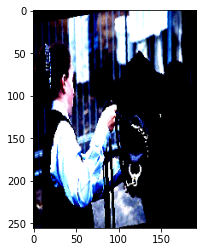

predicted


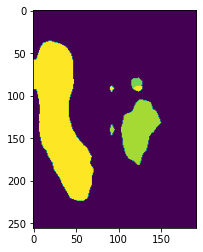

original


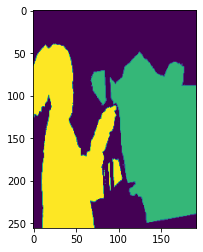

------------------------------------------------
For class 12


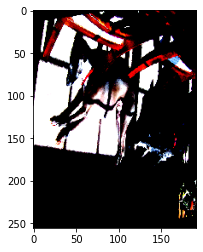

predicted


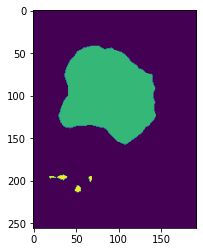

original


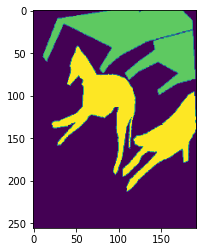

------------------------------------------------
For class 13


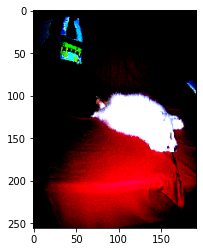

predicted


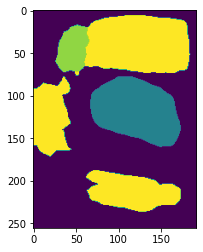

original


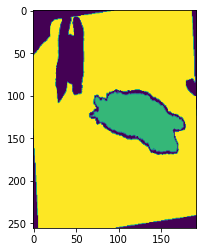

------------------------------------------------
For class 14


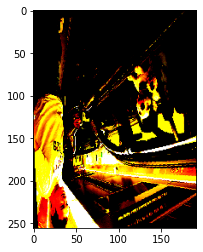

predicted


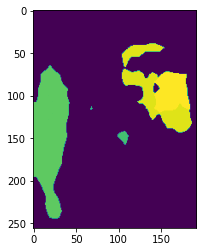

original


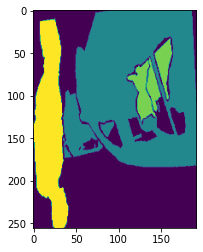

------------------------------------------------
For class 15


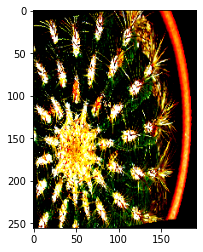

predicted


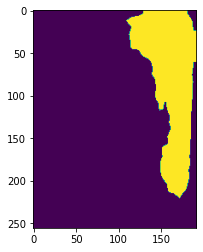

original


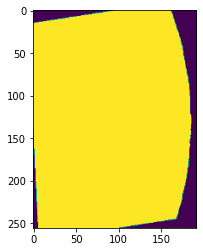

------------------------------------------------
For class 16
------------------------------------------------
For class 17
------------------------------------------------
For class 18
------------------------------------------------
For class 19
------------------------------------------------
For class 20
------------------------------------------------


In [ ]:
for h,i in z.items():
  print(f'For class {h}')
  for j in range(len(i)-1):
    if j ==0:
      
      plt.imshow(i[j].reshape(256,192,3))
      plt.show()
    else:
      if j==1:
        print('predicted')
      else:
        print('original')
      plt.imshow(i[j])
      plt.show()

  print('------------------------------------------------')
